# Data Analysis Notebook
Importación de librerías


In [2]:
import pandas as pd
import matplotlib
import sklearn
import time
import numpy as np

Lectura de ficheros de datos en formato csv

In [3]:
wind_ava=pd.read_csv('wind_ava.csv.gz', compression = "gzip")

wind_comp=pd.read_csv('wind_comp.csv.gz', compression = "gzip")

Visualización de las primeras muestras de datos de los ficheros iniciales

In [4]:
wind_ava.head()

,datetime,energy,p54.162.1,p54.162.2,p54.162.3,p54.162.4,p54.162.5,p54.162.6,p54.162.7,p54.162.8,...,v100.16,v100.17,v100.18,v100.19,v100.20,v100.21,v100.22,v100.23,v100.24,v100.25
0,2005-01-02 18:00:00,402.71,2.534970e+06,2.526864e+06,2.518754e+06,2.510648e+06,2.502537e+06,2.531111e+06,2.522721e+06,2.514330e+06,...,-4.683596,-4.545396,-4.407196,-4.268996,-4.131295,-4.669626,-4.528932,-4.388736,-4.248540,-4.107846
1,2005-01-03 00:00:00,696.80,2.537369e+06,2.529277e+06,2.521184e+06,2.513088e+06,2.504995e+06,2.533465e+06,2.525088e+06,2.516716e+06,...,-3.397886,-3.257192,-3.115998,-2.975304,-2.834609,-3.396390,-3.254198,-3.112506,-2.970314,-2.828622
2,2005-01-03 06:00:00,1591.15,2.533727e+06,2.525703e+06,2.517678e+06,2.509654e+06,2.501629e+06,2.529801e+06,2.521496e+06,2.513187e+06,...,-1.454105,-1.296447,-1.138290,-0.980134,-0.822476,-1.459094,-1.302933,-1.147271,-0.991110,-0.834949
3,2005-01-03 12:00:00,1338.62,2.534491e+06,2.526548e+06,2.518609e+06,2.510670e+06,2.502732e+06,2.530569e+06,2.522346e+06,2.514127e+06,...,1.255015,1.370265,1.485515,1.600765,1.716015,1.210612,1.319376,1.428140,1.536405,1.645169
4,2005-01-03 18:00:00,562.50,2.529543e+06,2.521623e+06,2.513702e+06,2.505782e+06,2.497861e+06,2.525621e+06,2.517421e+06,2.509215e+06,...,1.939031,2.023847,2.108663,2.193977,2.278793,1.873673,1.953000,2.031829,2.111157,2.189986


In [5]:
wind_ava['datetime'] = pd.to_datetime(wind_ava['datetime'])
wind_ava.head()

,datetime,energy,p54.162.1,p54.162.2,p54.162.3,p54.162.4,p54.162.5,p54.162.6,p54.162.7,p54.162.8,...,v100.16,v100.17,v100.18,v100.19,v100.20,v100.21,v100.22,v100.23,v100.24,v100.25
0,2005-01-02 18:00:00,402.71,2.534970e+06,2.526864e+06,2.518754e+06,2.510648e+06,2.502537e+06,2.531111e+06,2.522721e+06,2.514330e+06,...,-4.683596,-4.545396,-4.407196,-4.268996,-4.131295,-4.669626,-4.528932,-4.388736,-4.248540,-4.107846
1,2005-01-03 00:00:00,696.80,2.537369e+06,2.529277e+06,2.521184e+06,2.513088e+06,2.504995e+06,2.533465e+06,2.525088e+06,2.516716e+06,...,-3.397886,-3.257192,-3.115998,-2.975304,-2.834609,-3.396390,-3.254198,-3.112506,-2.970314,-2.828622
2,2005-01-03 06:00:00,1591.15,2.533727e+06,2.525703e+06,2.517678e+06,2.509654e+06,2.501629e+06,2.529801e+06,2.521496e+06,2.513187e+06,...,-1.454105,-1.296447,-1.138290,-0.980134,-0.822476,-1.459094,-1.302933,-1.147271,-0.991110,-0.834949
3,2005-01-03 12:00:00,1338.62,2.534491e+06,2.526548e+06,2.518609e+06,2.510670e+06,2.502732e+06,2.530569e+06,2.522346e+06,2.514127e+06,...,1.255015,1.370265,1.485515,1.600765,1.716015,1.210612,1.319376,1.428140,1.536405,1.645169
4,2005-01-03 18:00:00,562.50,2.529543e+06,2.521623e+06,2.513702e+06,2.505782e+06,2.497861e+06,2.525621e+06,2.517421e+06,2.509215e+06,...,1.939031,2.023847,2.108663,2.193977,2.278793,1.873673,1.953000,2.031829,2.111157,2.189986


Si modificamos el índice para que este sea la variable *datetime* nos será más simple operar con ello.

In [6]:
#wind_ava = wind_ava.set_index('datetime')
#wind_ava.head()


Actualmente, el fichero tiene 551 columnas. No las necesitamos todas: sólo usaremos la información sobre la localización de Sotavento, es decir, el número 13 de la cuadrícula de 5x5. 

A continuación, modificamos el fichero de datos para eliminar las columnas que no necesitamos y quedarnos únicamente con las columnas de variables relativas a la posición 13 de la cuadrícula. Para ello, filtramos las columnas según aquellas que contengan el número 13 en su nombre.
Además, nos interesa saber el valor de la energía en cada momento en esa localización, por lo que también filtraremos de forma que no se elimine la variable 'energy'.

In [7]:
for c in wind_ava.columns:
    if not c.endswith('.13') and c != 'energy' and c != 'datetime':
        wind_ava = wind_ava.drop(c, axis = 1)

In [8]:
wind_ava.head()

,datetime,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,...,t2m.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13
0,2005-01-02 18:00:00,402.71,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,...,280.473098,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617
1,2005-01-03 00:00:00,696.80,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,...,278.286616,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469
2,2005-01-03 06:00:00,1591.15,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,...,277.206490,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748
3,2005-01-03 12:00:00,1338.62,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,...,280.926600,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478
4,2005-01-03 18:00:00,562.50,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,...,277.363875,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114


Como se puede observar, hemos pasado de operar con 551 columnas, a tener sólo 23 columnas en nuestro dataset.
En último lugar, es necesario modificar la variable 'datetime' y convertir los datos de la primera columna a formato fecha (pd.to_datetime()) para facilitar su manejo y visualización. Podemos comprobar el resultado de esta modificación en los diagramas de la siguiente sección. 

## Descripción general de los datos

In [9]:
wind_ava

,datetime,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,...,t2m.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13
0,2005-01-02 18:00:00,402.71,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,...,280.473098,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617
1,2005-01-03 00:00:00,696.80,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,...,278.286616,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469
2,2005-01-03 06:00:00,1591.15,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,...,277.206490,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748
3,2005-01-03 12:00:00,1338.62,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,...,280.926600,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478
4,2005-01-03 18:00:00,562.50,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,...,277.363875,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4743,2009-12-30 06:00:00,1280.13,2.385772e+06,14.413342,24.971074,3.905586e+06,2.349839,2.434994,4.595786,5.563189,...,280.731326,282.643490,281.676560,0.628948,0.879581,286.013271,0.424510,-5.715421,6.922743,9.179816
4744,2009-12-30 12:00:00,855.00,2.385708e+06,12.802883,60.248874,2.745694e+06,2.349446,2.434849,4.894838,5.577096,...,283.310687,282.370909,281.761750,0.740926,0.699769,285.988737,0.424762,-5.732455,7.434887,7.537381
4745,2009-12-30 18:00:00,117.06,2.379049e+06,10.915997,3.145067,2.254171e+06,2.349054,2.434715,0.958361,0.948029,...,281.060085,282.425812,281.841961,0.109802,0.125174,285.968452,0.415132,-5.866856,3.033799,3.568993
4746,2009-12-31 12:00:00,516.96,2.371697e+06,13.048144,12.580268,1.376913e+06,2.347799,2.434291,5.278912,0.771754,...,279.662858,281.153379,281.976385,0.705886,0.192834,285.904895,0.426707,-5.693542,8.374951,2.219422


In [10]:
df_shape = wind_ava.shape
df_shape

(4748, 24)

Nuestro dataset tiene 23 características y 4748 instancias.

In [11]:
df_description = wind_ava.describe()
df_description

,datetime,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,...,t2m.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13
count,4748,4748.000000,4.748000e+03,4748.000000,4748.000000,4.748000e+03,4748.000000,4748.000000,4748.000000,4748.000000,...,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000
mean,2007-02-20 00:43:40.387531520,693.126247,2.489477e+06,16.008810,31.166541,1.706692e+06,2.815222,2.576284,0.386215,0.120528,...,285.689253,286.663838,286.665988,0.074229,0.049971,286.668152,0.413677,-5.908467,0.447175,0.328204
min,2005-01-02 18:00:00,0.010000,2.358748e+06,1.650268,0.000000,5.610341e+04,2.323973,2.425866,-8.619823,-8.867441,...,268.970603,275.461648,278.389271,-1.714897,-1.438829,280.875389,0.364805,-6.130465,-11.879053,-13.043453
25%,2005-12-11 04:30:00,144.170000,2.458543e+06,11.203264,0.000000,6.563209e+05,2.425944,2.461630,-1.950008,-2.050920,...,281.458939,282.287394,282.689506,-0.126880,-0.148495,283.405549,0.410027,-5.977599,-3.836853,-3.256194
50%,2006-11-18 15:00:00,465.305000,2.490478e+06,15.543441,1.004148,1.239176e+06,2.758857,2.560520,0.048820,-0.191853,...,285.395453,286.191880,286.204914,0.010551,-0.003569,286.591659,0.410917,-5.947220,0.282399,-0.389416
75%,2007-12-03 07:30:00,1089.375000,2.525134e+06,20.214077,14.143328,2.296548e+06,3.205385,2.688526,2.641779,2.016289,...,289.740438,291.345311,290.989045,0.232378,0.172325,290.024705,0.417070,-5.858848,4.187953,3.614395
max,2009-12-31 18:00:00,2792.550000,2.580387e+06,39.230807,2311.662152,1.110694e+07,3.450745,2.762992,12.974802,11.699814,...,305.000640,299.556292,295.639998,2.842552,2.366522,292.808658,0.428914,-5.618172,18.964137,16.913033
std,NaN,665.531609,4.482599e+04,6.552216,121.758977,1.466953e+06,0.397377,0.116434,3.100583,3.016766,...,6.163483,5.547947,4.582827,0.367013,0.379014,3.552873,0.007602,0.094359,4.841730,4.667552


Con esta información resumida sobre los datos disponibles podemos averiguar la media, el mínimo y el máximo y la desviación típica de cada variable, entre otras cosas. 

En primer lugar, podemos observar que todas nuestras variables son numéricas. 

También observamos que ningún valor de desviación estándar o desviación típica (std) es igual a 0, por lo que ninguna de las variables de nos interesan (las del sector 13 del mapa) son constantes, y por lo tanto no es necesario modificar el dataset más allá de lo relaizado hasta ahora.



# Preprocesado de datos
En primer lugar, queremos identificar y eliminar los datos faltantes en nuestro dataset, es decir, aquellos que son *NA*.
Para ello identificamos el número de datos faltantes por cada característica.

In [12]:
wind_ava.isna().sum()

datetime      0
energy        0
p54.162.13    0
p55.162.13    0
cape.13       0
p59.162.13    0
lai_lv.13     0
lai_hv.13     0
u10n.13       0
v10n.13       0
sp.13         0
stl1.13       0
u10.13        0
v10.13        0
t2m.13        0
stl2.13       0
stl3.13       0
iews.13       0
inss.13       0
stl4.13       0
fsr.13        0
flsr.13       0
u100.13       0
v100.13       0
dtype: int64

Como podemos ver, no hay ningún valor perdido en nuestros datos, por lo que no necesitamos eliminar ninguna característica. Lo habríamos hecho en el caso de que, para alguna característica, más del 80% de los datos fueran faltantes.

A continuación comprobamos que la desviación típica de todas las variables sea diferente de 0, lo que supondría que todas son significativas y aportan valor al modelo. En caso de que este dato tomara valor nulo supondría que esa variable es constante, y posiblemente se valoraría su eliminación del conjunto de datos.

In [13]:
wind_ava.std()

datetime      535 days 21:20:22.420055672
energy                         665.531609
p54.162.13                   44825.986737
p55.162.13                       6.552216
cape.13                        121.758977
p59.162.13                 1466952.650477
lai_lv.13                        0.397377
lai_hv.13                        0.116434
u10n.13                          3.100583
v10n.13                          3.016766
sp.13                          713.689654
stl1.13                          6.414325
u10.13                           3.158104
v10.13                           3.058615
t2m.13                           6.163483
stl2.13                          5.547947
stl3.13                          4.582827
iews.13                          0.367013
inss.13                          0.379014
stl4.13                          3.552873
fsr.13                           0.007602
flsr.13                          0.094359
u100.13                           4.84173
v100.13                          4

## Visualización de los datos
Una vez se ha preprocesado y limpiado el conjunto de los datos, se procede a la creación de diferentes diagramas para recolectar información sobre la distirbución de los datos.
Con un diagrama de barras se pueden apreciar las distribuciones de energía recogidas en cada instante de tiempo (representados como el índice del conjunto de datos).

<Axes: >

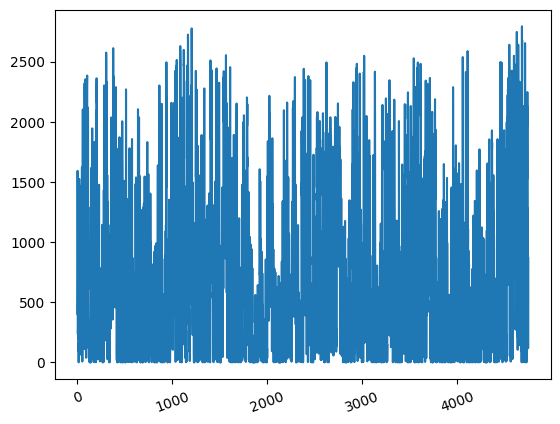

In [14]:
wind_ava['energy'].plot(rot=20)

Para poder identificar información sobre los outliers utilizamos un diagrama de caja o boxplot.

<Axes: >

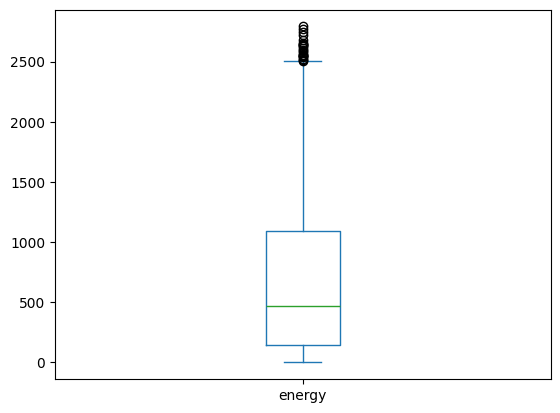

In [15]:
wind_ava['energy'].plot.box()

Se puede observar que hay bastantes outliers de energía generada. A pesar de que la mediana se encuentra alrededor de 500, y el tercer cuartil alrededor de 1000, existen bastantes valores fuera del rango intercuartílico, y todos ellos superando el valor de energía generada de 2500, mientras que por debajo del primer cuartil prácticamente no se percibe la existencia de outliers.

También se puede observar la frecuencia de energía en los diferentes rangos temporales (calulados con el números de divisiones *bins*) mediante un histograma.

<Axes: ylabel='Frequency'>

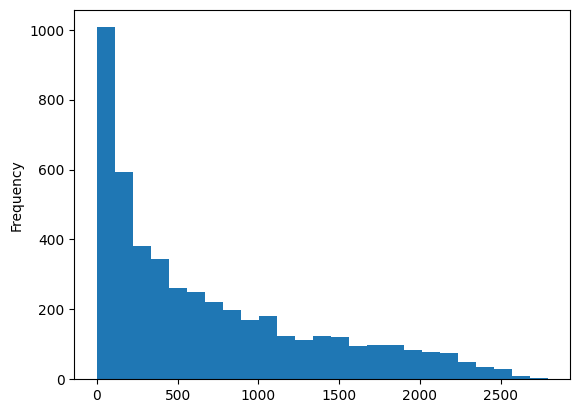

In [16]:
wind_ava['energy'].plot.hist(bins=25)

Se puede observar que la distribución se acumula a la izquierda de los valores temporales. Para solucionar un posible sesgo, se puede convertir la variable *energy* a logarítmica de forma que en el gráfico se aprecie como una distribución normal, en lugar de la actual que asemeja una distribución logarítmica.
Para realizar esta operación, utilizaremos la librería NumPy. Para ello inicialmente importamos la librería mencionada como se muestra a continuación:

In [17]:
import numpy as np

<Axes: ylabel='Frequency'>

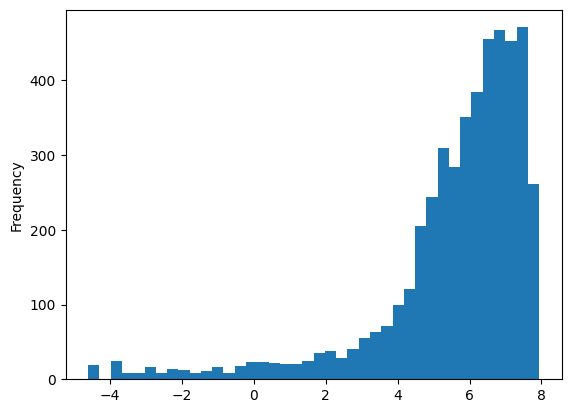

In [18]:
wind_ava['log_energy'] = np.log(wind_ava['energy'])

wind_ava['log_energy'].plot.hist(bins=40)

En este caso, el resultado no es especialmente relevante, ya que la operación convierte un sesgo a la izquierda en un sesgo a la derecha, de forma que el gráfico resultante no asemeja prácticamente una distirbución normal.

# Método de evaluación Outer & Inner
Tras haber estudiado y limpiado el conjunto de datos, se explica la estrategia que se llevará a cabo para evaluar el modelo (*outer*) y para definir el ajuste de hiperparámetros (*inner*).

*`Outer`* 
Para estimar el rendimiento esperado del modelo con datos futuros (para los que no ha sido entrenado), separamos una parte de los datos para evaluar (partición test) el modelo resultante del inner.

*`Inner`*
Emplearemos Grid Search con Cross Validation y Time Series Splits.

Para evlauar el rendimiento de los diferentes modelos se deben escoger una serie de métricas
RMSE y MAE y dummy regressor para escalar los datos y en base a ese dummy calcular RSE y RAE.
Para hacer el modelo dummy se le quita la media al real
ESto nos permite observar el error en términos absoluto y relativo
para cross validation MSE y de cara a la evaluación del modelo final tomaríamos todas esta medidas.

In [19]:
wind_ava.head()

,datetime,energy,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,...,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13,log_energy
0,2005-01-02 18:00:00,402.71,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,...,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617,5.998217
1,2005-01-03 00:00:00,696.80,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,...,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469,6.546498
2,2005-01-03 06:00:00,1591.15,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,...,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748,7.372212
3,2005-01-03 12:00:00,1338.62,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,...,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478,7.199395
4,2005-01-03 18:00:00,562.50,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,...,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114,6.332391


In [20]:
from sklearn import preprocessing, neighbors, metrics, pipeline, linear_model, svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [21]:
#División de conjuntos de evaluación outer. 
#Dividimos en train y test aprovechando una falta de datos para el año 2009.
train= wind_ava[wind_ava['datetime'].dt.year<2009]
X_train= train.drop(columns='energy')
y_train= train['energy']
print("train shape is:", train.shape,"\n X_train shape:",X_train.shape, "\n y_train shape: ", y_train.shape)

train shape is: (3827, 25) 
 X_train shape: (3827, 24) 
 y_train shape:  (3827,)


In [22]:
test= wind_ava[wind_ava['datetime'].dt.year>2008]
X_test= test.drop(columns='energy')
y_test= test['energy']
print("test shape is:", test.shape,"\n X_test shape:",X_test.shape, "\n y_train shape: ", y_test.shape)

test shape is: (921, 25) 
 X_test shape: (921, 24) 
 y_train shape:  (921,)


In [23]:
print(train.shape, test.shape, wind_ava.shape)

(3827, 25) (921, 25) (4748, 25)


In [24]:
y_test.head()

3827     977.91
3828    1191.99
3829     795.88
3830     141.05
3831    1124.20
Name: energy, dtype: float64

In [25]:
X_train = X_train.set_index('datetime')
X_train.head()

,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,stl1.13,...,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13,log_energy
datetime,,,,,,,,,,,,,,,,,,,,,
2005-01-02 18:00:00,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,99846.319914,280.960661,...,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617,5.998217
2005-01-03 00:00:00,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,99917.733093,279.296651,...,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469,6.546498
2005-01-03 06:00:00,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,99764.378681,278.233956,...,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748,7.372212
2005-01-03 12:00:00,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,99672.670459,280.787263,...,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478,7.199395
2005-01-03 18:00:00,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,99372.811211,279.583112,...,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114,6.332391


In [26]:
X_test = X_test.set_index('datetime')

# Selección de Scaler
En esta sección se emplea KNN y CV para encontrar el método de escalado que minimice el error entre las tres opciones que ofrece sklearn: MinMax, Standarization y Robust. 
Para ello, empleamos un sencillo crossvalidation con un split adecuado para series temporales y medimos el error empleando la métrica escogida (MSE).

In [27]:
#1) Preparación de datos -usaremos el subset train. 
scalerCV= TimeSeriesSplit(n_splits=5)
scaler_eval= {}

In [28]:
#2)Evaluación de scalers
#StandardScaler
from sklearn.preprocessing import StandardScaler
pipeline_std = sklearn.pipeline.Pipeline([('scaler', StandardScaler()),
                                           ('KNN', neighbors.KNeighborsRegressor())])

score_std = cross_val_score(pipeline_std, X_train, y_train,cv= scalerCV, scoring='neg_mean_squared_error')

scaler_eval["StandardScaler"] = -score_std.mean()

In [29]:
#MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
pipeline_mnmx = sklearn.pipeline.Pipeline([('scaler', MinMaxScaler()),
                                           ('KNN', neighbors.KNeighborsRegressor())])

score_mnmx = cross_val_score(pipeline_mnmx, X_train, y_train,cv= scalerCV, scoring='neg_mean_squared_error')

scaler_eval["MinMaxScaler"] = -score_mnmx.mean()

In [30]:
#RobustScaler
from sklearn.preprocessing import RobustScaler
pipeline_rbst = sklearn.pipeline.Pipeline([('scaler', RobustScaler()),
                                           ('KNN', neighbors.KNeighborsRegressor())])

score_rbst = cross_val_score(pipeline_rbst, X_train, y_train,cv= scalerCV, scoring='neg_mean_squared_error')

scaler_eval["RobustScaler"] = -score_rbst.mean()

In [31]:
print(scaler_eval)

{'StandardScaler': 149995.7340766405, 'MinMaxScaler': 179612.1533617457, 'RobustScaler': 137309.88759058836}


Usando MSE o RMSE, el error más pequeño que hemos obtenido es el de RobustScaler con un valor de 137309.

In [32]:
pipeline_mnmx.fit(X_train, y_train)
y_pred = pipeline_mnmx.predict(X_test)
outer_score = metrics.mean_squared_error(y_test, y_pred)
print(outer_score)

151540.96712243214


# Selección de Método
En esta sección se miden los tiempos de entrenamiento de diferentes propuestas de modelo para solucionar el problema planeado. 
A continuación, se realiza una optimización e hiperparámetros (HPO) sobre dichos modelos candidatos y se realizan mediciones temporales del proceso. 
Finalmente, se emplean los datos recopilados (tiempo y scores de los modelos) para analizar y extraer conclusiones, escogiendo el modelo final que se empleará para solucionar el problema de predicción propuesto. 

# 1) Mediciones iniciales
Se probarán y evaluarán modelos por defecto de KNN, árboles de regresión, regresión lineal y SMV.

In [33]:
time_split= TimeSeriesSplit(n_splits=5)

times= {}

In [34]:
#A. KNN

#knn train measurement
time0= time.time()
model= sklearn.pipeline.Pipeline([('scaler',RobustScaler()),
                                ('KNN', neighbors.KNeighborsRegressor())])
model.fit(X_train, y_train)

time1= time.time()
knn_train= time1 - time0

#knn cross validation measurement
time0= time.time()
knn_score= cross_val_score(model, X_train, y_train, cv= time_split, scoring='neg_mean_squared_error')
time1= time.time()
knn_cv= time1 - time0

times["KNN"]= {"train_time": knn_train, "cv_time":knn_cv, "total_time":knn_train + knn_cv, "score": -knn_score.mean()}

print("KNN: ", times["KNN"])

KNN:  {'train_time': 0.015958309173583984, 'cv_time': 0.11693263053894043, 'total_time': 0.13289093971252441, 'score': 137309.88759058836}


In [35]:
#B. Árboles de regresión

#tree train measurement
time0= time.time()
model= sklearn.pipeline.Pipeline([('scaler',RobustScaler()),
                                ('RegTree', DecisionTreeRegressor())])
model.fit(X_train, y_train)

time1= time.time()
tree_train= time1 - time0

#tree cross validation measurement
time0= time.time()
tree_score= cross_val_score(model, X_train, y_train, cv= time_split, scoring='neg_mean_squared_error')
time1= time.time()
tree_cv= time1 - time0

times["Tree"]= {"train_time": tree_train, "cv_time":tree_cv, "total_time":tree_train + tree_cv, 
                "score": -tree_score.mean()}
print("Tree: ", times["Tree"])

Tree:  {'train_time': 0.15067481994628906, 'cv_time': 0.32895946502685547, 'total_time': 0.47963428497314453, 'score': 51.19941682888542}


In [36]:
#C. Regresor lineal: standard y lasso
#C.1. Regular
time0= time.time()
model= sklearn.pipeline.Pipeline([('scaler',RobustScaler()),
                                ('Linear Reg', linear_model.LinearRegression())])
model.fit(X_train, y_train)
time1= time.time()
linear_train= time1 - time0

time0= time.time()
linear_score= cross_val_score(model, X_train, y_train, cv= time_split, scoring='neg_mean_squared_error')
time1= time.time()
linear_cv= time1 - time0

times["Linear"]= {"train_time": linear_train, "cv_time":linear_cv, "total_time":linear_train + linear_cv, 
                "score": -linear_score.mean()}
print("Linear Reg: ", times["Linear"])

Linear Reg:  {'train_time': 0.024933338165283203, 'cv_time': 0.07732295989990234, 'total_time': 0.10225629806518555, 'score': 193363.5238433415}


In [37]:
#C.2. Lasso
time0= time.time()
model= sklearn.pipeline.Pipeline([('scaler',RobustScaler()),
                                ('Lasso Reg', linear_model.Lasso())])
model.fit(X_train, y_train)
time1= time.time()
lasso_train= time1 - time0

time0= time.time()
lasso_score= cross_val_score(model, X_train, y_train, cv= time_split, scoring='neg_mean_squared_error')
time1= time.time()
lasso_cv= time1 - time0

times["Lasso"]= {"train_time": lasso_train, "cv_time":lasso_cv, "total_time":lasso_train + lasso_cv, 
                "score": -lasso_score.mean()}
print("Lasso Reg: ", times["Lasso"])

Lasso Reg:  {'train_time': 0.04089093208312988, 'cv_time': 0.139235258102417, 'total_time': 0.18012619018554688, 'score': 192289.20671157766}


C:\Users\crist\OneDrive\Documentos\.Universidad\Machine Learning\P1_ML\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.701e+04, tolerance: 2.629e+04
  model = cd_fast.enet_coordinate_descent(


In [38]:
#D. SMV
time0= time.time()
model= sklearn.pipeline.Pipeline([('scaler',RobustScaler()),
                                ('SMV', svm.SVR())])
model.fit(X_train, y_train)
time1= time.time()
smv_train= time1 - time0

time0= time.time()
smv_score= cross_val_score(model, X_train, y_train, cv= time_split, scoring='neg_mean_squared_error')
time1= time.time()
smv_cv= time1 - time0

times["SMV"]= {"train_time": smv_train, "cv_time": smv_cv, "total_time":smv_train + smv_cv, 
                "score": -smv_score.mean()}
print("SMV: ", times["SMV"])

SMV:  {'train_time': 1.3131041526794434, 'cv_time': 2.4158236980438232, 'total_time': 3.7289278507232666, 'score': 449842.01510665164}


## 2) Optimización de hiperparámetros
A continuación, se ajustarán los hiperparámetros de cada método estudiado con GridSearch como se decidió anteriormente, obteniendo la evaluación correspondiente al mejor modelo encontrado con dicho método y el tiempo de ejecución total del entrenamiento.

In [39]:
from sklearn.model_selection import GridSearchCV

hpo_times = {}

In [ ]:
#A. KNN
time0= time.time()
param_grid = {'knn__n_neighbors': list(range(2,35,2)),
              'knn__weights': ['uniform', 'distance'], 
              'knn__algorithm': ['ball_tree', 'kd_tree','brute']} #se pueden añadir más (metric, leaf-size..)

knn_model= sklearn.pipeline.Pipeline([('scaler',RobustScaler()),
                                ('knn', neighbors.KNeighborsRegressor())])
knn_regr = GridSearchCV(knn_model,
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=time_split, 
                   n_jobs=1, verbose=1)
np.random.seed(55)
knn_regr.fit(X=X_train, y=y_train)
time1= time.time()
knn_train = time1 - time0

times["KNN"]= {"train_time": knn_train, "best_params": knn_regr.best_params_, "best_score": -knn_regr.best_score_}
print("KNN: ", times["KNN"])


In [41]:
#B. Árboles de regresión
time0= time.time()
param_grid = {'max_depth': list(range(2,35,2)),
              'min_samples_split': list(range(2,20,2))}

tree_regr = GridSearchCV(DecisionTreeRegressor(), 
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=time_split, 
                   n_jobs=1, verbose=1)
np.random.seed(55)
tree_regr.fit(X=X_train, y=y_train)
time1= time.time()
tree_train = time1 - time0

times["RegTree"]= {"train_time": tree_train, "best_params": tree_regr.best_params_, "best_score": -tree_regr.best_score_}
print("RegTree: ", times["RegTree"])

Fitting 5 folds for each of 153 candidates, totalling 765 fits
RegTree:  {'train_time': 26.79049062728882, 'best_params': {'max_depth': 16, 'min_samples_split': 2}, 'best_score': 48.71087463108318}


In [42]:
#C. Regresor lineal: standard y lasso ¿Tiene hiper-parámetros?

In [ ]:
#D. SMV
time0= time.time()
param_grid = {'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 
              'svm__degree': list(range(2,10,2)), 
              'svm__gamma': ['scale', 'auto']} #se pueden añadir más

svm_model= sklearn.pipeline.Pipeline([('scaler',RobustScaler()),
                                ('svm', svm.SVR())])
svm_regr = GridSearchCV(svm_model,
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=time_split, 
                   n_jobs=1, verbose=1)
np.random.seed(55)
svm_regr.fit(X=X_train, y=y_train)
time1= time.time()
svm_train = time1 - time0

times["SVM"]= {"train_time": svm_train, "best_params": svm_regr.best_params_, "best_score": -svm_regr.best_score_}
print("SVM: ", times["SVM"])